In [1]:
#Get features (stops words removed) by tokenizing corpus - no stemming in baseline
#Binary encoding
#Assign target group 
#Use mutual information to get final feature set

In [1]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Testing Feature Selection
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.stem import *

# download required resources
nltk.download("wordnet")

# we'll compare two stemmers and a lemmatizer
lrStem = LancasterStemmer()
sbStem = SnowballStemmer("english")
prStem = PorterStemmer()
wnLemm = WordNetLemmatizer()
def wnLemm_v(word):
    wnLemm = WordNetLemmatizer()
    word = wnLemm.lemmatize(word, 'v')
    return word

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Padmanie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def importData():
    #Import Labelled Data
    DATA_DIR = "Data"
    thispath = Path().absolute()
    #dtype = {"index": str, "title": str, "description": str, "url": str, "date": str, "Retail Relevance": str, "Economy Relevant": str, "Market moving": str}
    RET_ARTICLES = os.path.join(DATA_DIR, "Labelled_Articles_.xlsx")
    
    df = pd.read_excel(RET_ARTICLES)

    try:
        df.head()
    except:
        pass
    return df

In [4]:
def assignStopWords(): 
    #Stop_words list Options
    #Variation 1: added stop words starting at 'one'
    stop_words = stopwords = [
        # dates/times
        "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "jan", "feb","mar", "apr", "jun", "jul", "aug", "oct", "nov", "dec", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "morning", "evening",
        # symbols that don't separate a sentence
        '$','“','”','’','—',
        # specific article terms that are useless
        "read", "share", "file", "'s","i", "photo", "percent","s", "t", "inc.", "corp", "group", "inc", "corp.", "source", "bloomberg", "cnbc","cnbcs", "cnn", "reuters","bbc", "published", "broadcast","york","msnbc",
        # other useless terms
        "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "co", "inc", "com", "theyve", "theyre", "theres", "heres", "didnt", "wouldn", "couldn", "didn","nbcuniversal","according", "just", "us", "ll", "times"#,
        # etc
        "from","the", "a", "with", "have", "has", "had", "having", "hello", "welcome", "yeah", "wasn", "today", "etc", "ext","definitely", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "while", "of", "said", "by", "for", "about", "into", "through", "during", "before", "after", "to", "from", "in", "out", "with", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "just", "don", "now", "will"
        ]
    #from nltk.corpus import stopwords
    #stop_words = set(stopwords.words('english'))
    #print(stop_words)
    return stop_words

In [5]:
def corpus_count_words(df, stop_words, text_col = 'content', normalizer=None):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for row in df.itertuples(index=True, name='Pandas'):
            attribute = str((row, text_col))
            file_words = tokenizer.tokenize(attribute)
            #keep lowercased words that are not stop words as features
            file_wordsNS = [word.lower() for word in file_words if not word.lower() in stop_words]
            # remove words that are numbers
            file_wordsN = [word for word in file_wordsNS if not word.isnumeric()]
            #remove words with a word length less than 4 (i.e. 1-3)
            file_wordsF = [word for word in file_wordsN if not len(word)<4]
            
            #stem
            if normalizer:
                file_wordsF = [normalizer(word) for word in file_wordsF]
            
            word_counter.update(file_wordsF)
    return word_counter

In [6]:
# news_cnt = corpus_count_words(df1,stop_words)

In [7]:
# news_cnt.most_common(30)

In [8]:
#Binary encoding for features, also appends retail target group
def binary_encode_features(newsarticles, top_words, text_col = 'content', normalizer=None):
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for row in tqdm(newsarticles.itertuples(index=True, name='Pandas')):
            attribute = str((row, text_col))
            file_words = tokenizer.tokenize(attribute)
            if normalizer:
                file_words = [normalizer(word) for word in file_words]
            df_rows.append([1 if word.lower() in file_words else 0 for word in top_words])      
    X = pd.DataFrame(df_rows, columns = top_words)
    
    return X

In [9]:
def mutualInformation(B_Encoding, y, top_words): 
    #Estimate mutual information for a discrete target variable.
    #Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables.
    #It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
    featureVals= mutual_info_classif(B_Encoding, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    
    np.asarray(featureVals)

    Temp= pd.DataFrame(featureVals, columns = ['MI_Values'])
 
    Final = Temp.assign(target_group = top_words)
    
    Highest_Features = Final.nlargest(10000, 'MI_Values')
    
    return Highest_Features

In [10]:
def selectFeatures(text_col = 'content', **kwargs):
    df = importData()
    stop_words = assignStopWords()
    
    if ('norm' in kwargs):
        norm = kwargs['norm']
        normalizers = {'lrStem' : lrStem.stem,
                       'sbStem' : sbStem.stem,
                       'prStem' : prStem.stem,
                       'wnLemm' : wnLemm.lemmatize,
                       'wnLemm-v':wnLemm_v,
                       'baseline':None
                      }
        normalizer = normalizers[norm]
    
    #Select subset of orig data
    #print(df.head(2))
    df1 = df[[text_col,'market_moving']]    
    news_cnt = corpus_count_words(df1, stop_words, text_col = text_col, normalizer = normalizer)
    
    print("starting Binary Encoding")
    num_features = 1000
    top_words = [word for (word, freq) in news_cnt.most_common(num_features)]
    B_Encoding = binary_encode_features(df1, top_words, text_col = text_col, normalizer = normalizer)
    print(B_Encoding.head())
    y = df['market_moving']
    B_Encoding.assign(target_group=y)
      
    print("Finished Bin Encoding. Collecting Highest Features")
    Highest_Features = mutualInformation(B_Encoding, y, top_words)
    Highest_Features = pd.DataFrame(Highest_Features)
    
    # Save as csv file in DATACOLLECTION data folder (bc it's needed for encoding script)
    if ('csv' in kwargs) and (kwargs['csv']):
        
        # File path for this file
        file_name = norm + text_col + 'FeatureSet.csv'
        thispath = Path().absolute()
        OUTPUT_DIR = os.path.join(thispath, "Data", file_name)
        
        # if the following line throws an error, use the line after to save in same folder
        pd.DataFrame.to_csv(Highest_Features, path_or_buf=OUTPUT_DIR)
        #pd.DataFrame.to_csv(Highest_Features, path_or_buf=file_name)
    
    print(Highest_Features)
    return Highest_Features

In [11]:
def main():
    HF = selectFeatures(csv = True, )
    return HF

In [16]:
nrms = ['wnLemm-v', 'lrStem', 'sbStem', 'prStem', 'wnLemm']
txtcols = ['title', 'content']

for txtcol in txtcols:
    #for nrm in nrms:
    nrm = nrms[4]
    print(txtcol + ': ' + nrm)
    HF = selectFeatures(text_col = txtcol, norm = nrm, csv=True, )
    

title: wnLemm
starting Binary Encoding


3330it [00:03, 1031.20it/s]


   title  index  panda  market_moving  amazon  stock  tech  market  apple  \
0      1      0      0              1       0      0     0       0      0   
1      1      0      0              1       0      0     0       0      0   
2      1      0      0              1       0      0     0       0      0   
3      1      0      0              1       0      0     0       0      0   
4      1      0      0              1       0      0     0       0      0   

   wall  ...    battery  coin  regret  weak  blockbuster  roll  beer  korea  \
0     0  ...          0     0       0     0            0     0     0      0   
1     0  ...          0     0       0     0            0     0     0      0   
2     0  ...          0     0       0     0            0     0     0      0   
3     0  ...          0     0       0     0            0     0     0      0   
4     0  ...          0     0       0     0            0     0     0      0   

   drink  crude  
0      0      0  
1      0      0  
2      0

3330it [00:54, 61.05it/s]


   company  year  content  market  amazon  would  business  like  index  \
0        1     1        1       0       0      1         1     1      0   
1        0     1        1       1       0      1         0     0      0   
2        1     1        1       0       0      1         1     0      0   
3        1     1        1       0       1      1         0     1      0   
4        1     0        1       0       1      1         1     0      0   

   people  ...    combined  pace  skill  supplier  echo  couple  leaving  \
0       1  ...           0     0      0         0     0       0        0   
1       1  ...           0     0      0         0     0       0        0   
2       1  ...           0     0      0         0     0       0        0   
3       1  ...           0     0      0         0     0       0        0   
4       1  ...           0     0      0         0     0       0        0   

   developer  continues  movie  
0          1          0      0  
1          0          0   

In [31]:
Highest_Features = main()

# Let Paddy know the code is done:
import winsound
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)
winsound.Beep(600, 500)
winsound.Beep(freq, duration)
winsound.Beep(600, 500)

   article_id                                              title  \
0           6  Mr. Cook, Bring Back Apple's Most Important Fi...   
1          12  These people move fast: Wealthy families are s...   
2          18  Are GE Investors Still Tipsy on New Year's Cha...   
3          24  What Canada can teach the US about immigration...   
4          30          D.E. Shaw Builds Activist Stake in Lowe's   

                                         description  \
0  The company used to say how many iPhone custom...   
1  Wealthy families are speedy dealmakers, and th...   
2      They seem to have gotten ahead of themselves.   
3  Congress should look at Canada for ideas about...   
4  Investor D.E. Shaw & Co. has built an active s...   

                                                 url                date  \
0  https://www.bloomberg.com/gadfly/articles/2018... 2018-01-11 14:57:45   
1  https://www.bloomberg.com/professional/blog/pe... 2018-01-11 22:04:44   
2  https://www.bloomberg.c

3148it [04:01, 13.77it/s]


   compani  year  content  amazon  market  like  would  also  busi  index  \
0        0     1        1       0       0     0      1     1     0      0   
1        0     1        1       0       0     1      1     1     0      0   
2        0     1        1       0       0     0      1     0     0      0   
3        0     1        1       0       0     1      1     1     0      0   
4        0     0        1       0       0     0      0     0     0      0   

     ...     cage  onlook  kim  depositor  barb  techcrunch  vein  overreach  \
0    ...        0       0    0          0     0           0     0          0   
1    ...        0       0    0          0     0           0     0          0   
2    ...        0       0    0          0     0           0     0          0   
3    ...        0       0    0          0     0           0     0          0   
4    ...        0       0    0          0     0           0     0          0   

   multist  sclerosi  
0        0         0  
1        0

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Padmanie\\Documents\\GitHub\\Capstone\\DataCollection\\Scripts\\Data\\lr-stem-test-retailFeatureSet-MI.csv'

In [28]:
import winsound
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)
winsound.Beep(600, 500)
winsound.Beep(freq, duration)
winsound.Beep(600, 500)

In [18]:
featureSet = pd.DataFrame(Highest_Features['target_group'])
    
# Save as csv file in DATACOLLECTION data folder (bc it's needed for encoding script)


# File path for this file
file_name = 'retailFeatureSet.csv'
thispath = Path().absolute()
OUTPUT_DIR = os.path.join(thispath, "Data", file_name)

# if the following line throws an error, use the line after to save in same folder
pd.DataFrame.to_csv(featureSet, path_or_buf=OUTPUT_DIR)

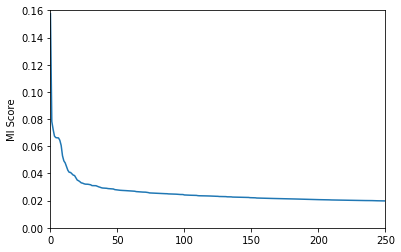

In [19]:
import matplotlib.pyplot as plt
plt.plot(Highest_Features['MI_Values'].values)
plt.ylabel('MI Score')
plt.axis([0, 250, 0, 0.16])
plt.show()

In [15]:
Highest_Features['MI_Values'].values

array([0.15685016, 0.08263148, 0.08260702, 0.07286888, 0.0727404 ,
       0.0654984 , 0.06318497, 0.05706316, 0.05342845, 0.05229887,
       0.04736192, 0.04527032, 0.03910597, 0.0382909 , 0.03785268,
       0.03732769, 0.03720455, 0.03714783, 0.0370412 , 0.03674766,
       0.03660287, 0.0365798 , 0.03439267, 0.03418774, 0.03344898,
       0.0327996 , 0.03204193, 0.03201651, 0.03143229, 0.0311371 ,
       0.03046653, 0.02992761, 0.02967316, 0.02956049, 0.02928386,
       0.02852677, 0.0283682 , 0.02813763, 0.02805806, 0.02797806,
       0.0274677 , 0.02681647, 0.02657687, 0.02647535, 0.02632202,
       0.02631743, 0.02626254, 0.02589552, 0.02561664, 0.02521897,
       0.02488037, 0.02471711, 0.02451793, 0.0243018 , 0.02428727,
       0.02358891, 0.02354837, 0.02335415, 0.02304278, 0.0228199 ,
       0.02278789, 0.02273341, 0.02271051, 0.02265611, 0.0225839 ,
       0.02241316, 0.02238736, 0.02237391, 0.02223753, 0.02202336,
       0.02195768, 0.02182063, 0.02170697, 0.02108735, 0.02104

In [12]:
Highest_Features

,MI_Values,target_group
8,0.159686,target
13,0.077075,stores
44,0.076992,inflation
28,0.073780,store
171,0.073689,child
26,0.073004,bank
37,0.071416,retailer
92,0.066799,central
389,0.064056,monetary
15,0.059455,online
